## Imports

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import json
import os # operating system

## Reading the data

In [41]:
file_name = 'XY_train.csv'
current_dir = os.getcwd()
file_path = os.path.join(current_dir, 'XY_train.csv')
df = pd.read_csv(file_path).drop(columns = ['ID'])

df.head()

,GENDER,EDUCATION,INCOME,CREDIT_SCORE,VEHICLE_OWNERSHIP,VEHICLE_YEAR,MARRIED,CHILDREN,POSTAL_CODE,ANNUAL_MILEAGE,VEHICLE_TYPE,SPEEDING_VIOLATIONS,PAST_ACCIDENTS,AGE,DRIVING_EXPERIENCE,OUTCOME
0,female,high school,upper class,0.545417,1,after 2015,1,1,10238,8000.0,sedan,4,6,80,39,0
1,male,none,poverty,0.361876,0,before 2015,1,1,10238,9000.0,sedan,0,0,26,2,1
2,female,university,middle class,0.535840,1,before 2015,1,0,10238,12000.0,sedan,0,0,29,7,0
3,female,high school,upper class,0.612545,1,after 2015,1,0,32765,9000.0,sedan,3,0,60,13,0
4,male,university,middle class,0.474268,1,before 2015,0,0,32765,13000.0,sedan,0,0,52,0,1


## Graphs

### Dataset balance

In [42]:
def create_histogram_of_priopr_probs_for_outcome(column: pd.Series) -> plt.figure:
    counts = column.value_counts(normalize=True)
    fig, ax = plt.subplots(figsize=(8, 6))
    counts.plot(kind='bar', color=['Purple', 'lightblue'])
    for i, value in enumerate(counts):
        percentage = f"{value * 100:.1f}%"  # Format as percentage
        ax.text(i, value, percentage, ha='center', va='bottom', fontsize=10)
    
    ax.set_title(f'Prior Probabilities of {column.name}')
    ax.set_xlabel(column.name)
    ax.set_ylabel('Probability')
    plt.ylim(0, 1.1)  # Adjust y-axis to give space for text
    return fig

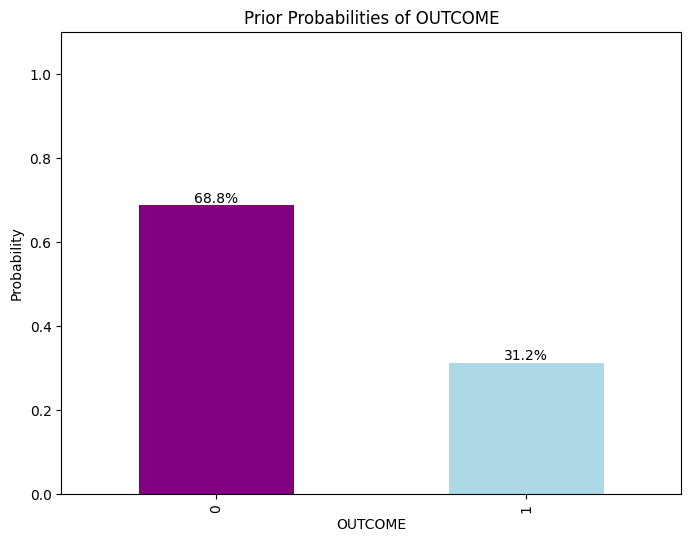

In [43]:
histogram_of_prob_outcome = create_histogram_of_priopr_probs_for_outcome(df['OUTCOME'])
plt.show()

### Histogram Plots

In [ ]:
def create_histogram_per_column(column: pd.Series) -> plt.Figure:
    fig, ax = plt.subplots(figsize=(8, 6))
    bins = 20 if column.name == 'ANNUAL_MILEAGE' else range(column.min(), column.max() + 2)
    ax.hist(column, bins=bins, edgecolor='k', alpha=0.7)
    ax.set_title('Distribution of ' + column.name, fontsize=14)
    ax.set_xlabel(column.name, fontsize=12)
    ax.set_ylabel('Frequency', fontsize=12)
    ax.grid(False)
    return fig

def hist_mean_srdv_per_column(column: pd.Series):
    print(f"Statistics for: {column.name}")
    mean = column.mean()
    std = column.std()
    print(f"Mean: {mean:.2f}")
    print(f"Standard Deviation: {std:.2f}")
    print()

Statistics for: DRIVING_EXPERIENCE
Mean: 15.36
Standard Deviation: 10.53



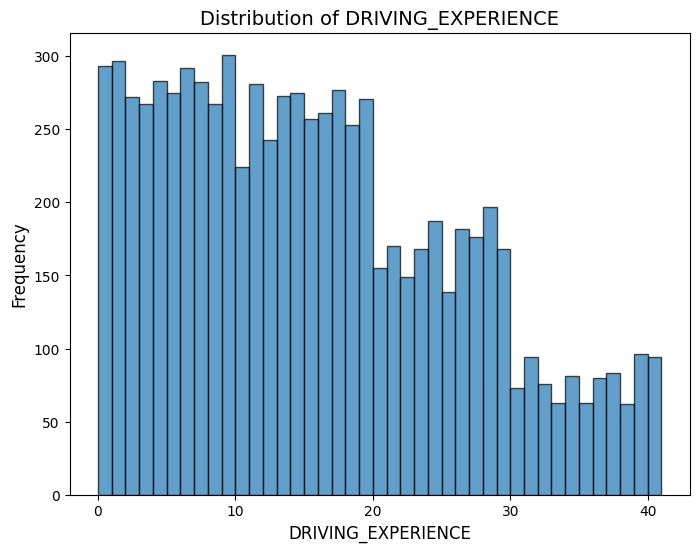

In [44]:
driving_exp = create_histogram_per_column(df['DRIVING_EXPERIENCE'])
hist_mean_srdv_per_column(df['DRIVING_EXPERIENCE'])
plt.show()

Statistics for: AGE
Mean: 43.75
Standard Deviation: 18.98



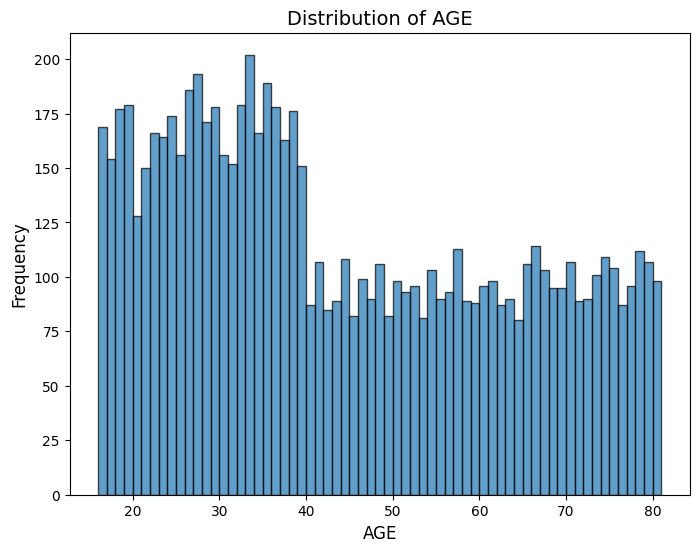

In [45]:
age_hist = create_histogram_per_column(df['AGE'])
hist_mean_srdv_per_column(df['AGE'])
plt.show()

Statistics for: PAST_ACCIDENTS
Mean: 1.08
Standard Deviation: 1.67



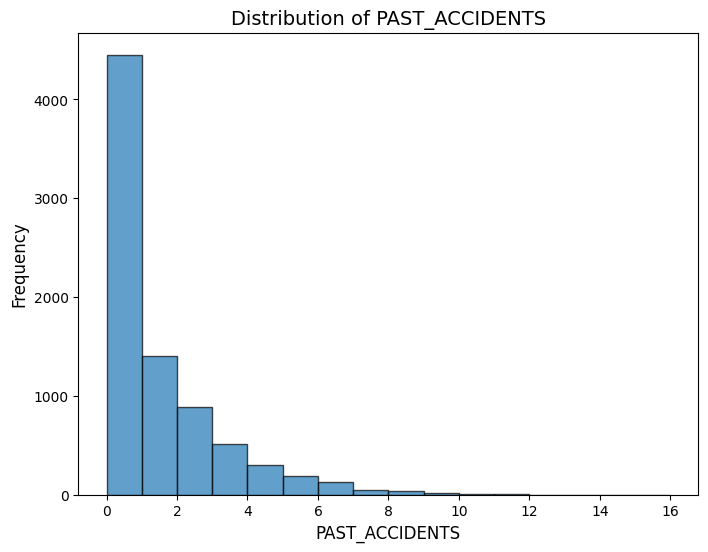

In [46]:
past_acc = create_histogram_per_column(df['PAST_ACCIDENTS'])
hist_mean_srdv_per_column(df['PAST_ACCIDENTS'])
plt.show()

Statistics for: ANNUAL_MILEAGE
Mean: 11694.74
Standard Deviation: 2815.76



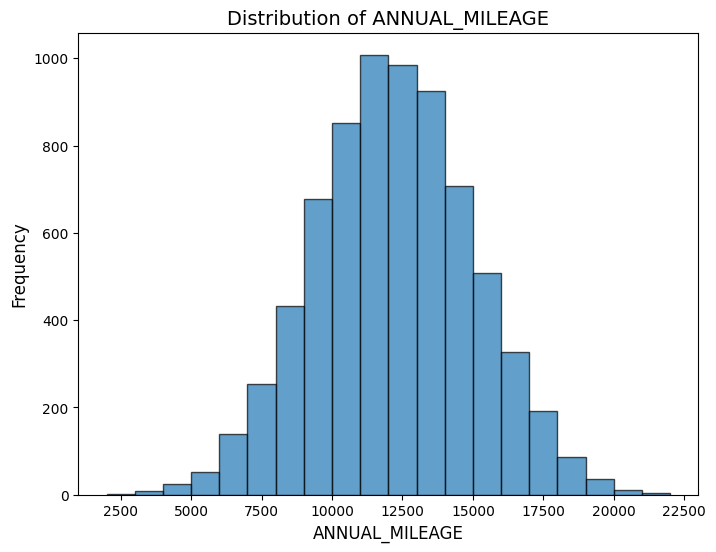

In [48]:
annual_mileage = create_histogram_per_column(df['ANNUAL_MILEAGE'])
hist_mean_srdv_per_column(df['ANNUAL_MILEAGE'])
plt.show()

### Interesting Relations

In [49]:
def create_scatter_plot_for_two_columns (column1: pd.Series, column2: pd.Series) -> plt.figure:
    fig, ax = plt.subplots(figsize=(8, 6))
    sns.regplot(x=column1, y=column2, scatter_kws={'alpha':0.6}, line_kws={'color':'red'})
    ax.set_title(f'{column1.name} vs. {column2.name}', fontsize=14)
    ax.set_xlabel(column1.name, fontsize=12)
    ax.set_ylabel(column2.name, fontsize=12)
    ax.grid(False)
    return fig

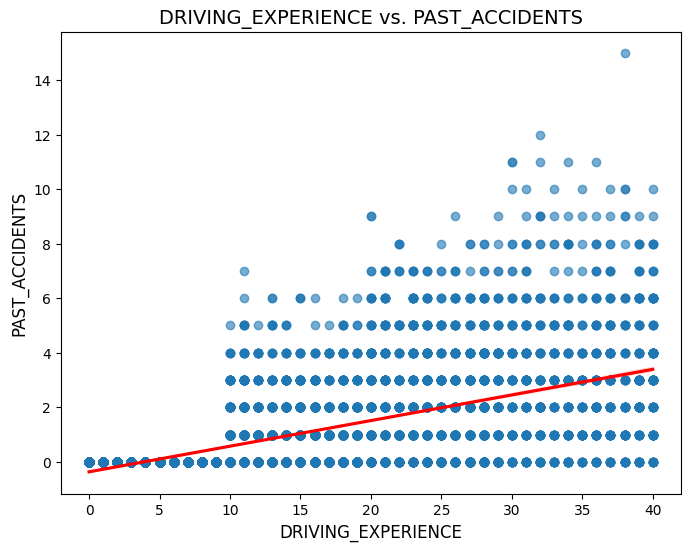

In [50]:
scatter_driving_past_accidents = create_scatter_plot_for_two_columns(df['DRIVING_EXPERIENCE'], df['PAST_ACCIDENTS'])
plt.show()

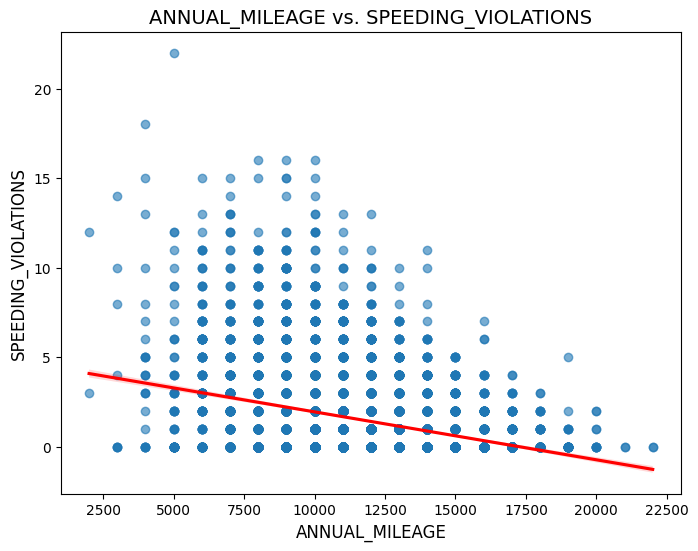

In [51]:
scatter_annual_speeding_violations = create_scatter_plot_for_two_columns(df['ANNUAL_MILEAGE'], df['SPEEDING_VIOLATIONS'])
plt.show()

### BoxPlots

In [56]:
def create_boxplot_for_2_columns (column1: pd.Series, column2: pd.Series) -> plt.figure:
    sns.boxplot(hue=column1, y=column2, palette='Set3')
    plt.title(f'{column2.name} Distribution by {column1.name}', fontsize=14)
    plt.xlabel(column1.name, fontsize=12)
    plt.ylabel(column2.name, fontsize=12)
    plt.show()

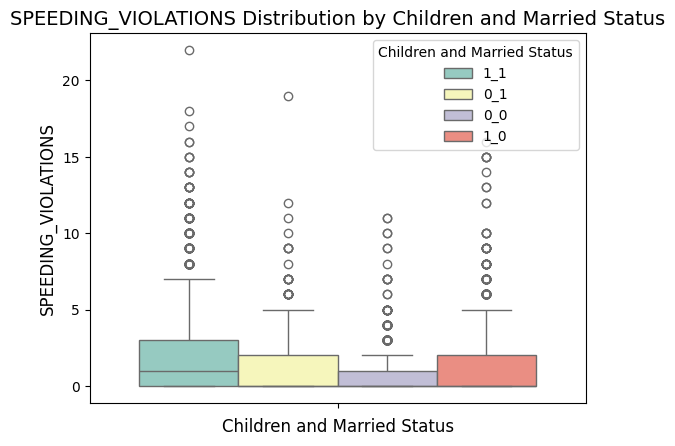

In [57]:
combined_column = df['CHILDREN'].astype(str) + '_' + df['MARRIED'].astype(str)
combined_column.name = 'Children and Married Status'
boxplot_married_and_children_by_speeding_violations = create_boxplot_for_2_columns(combined_column , df['SPEEDING_VIOLATIONS'])
plt.show()

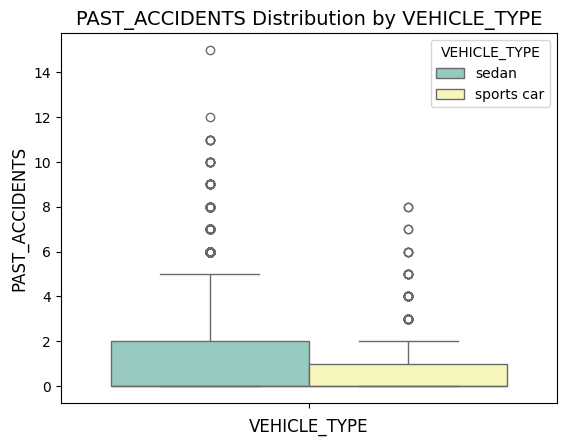

In [58]:
boxplot_vehicletype_accidents = create_boxplot_for_2_columns(df['VEHICLE_TYPE'], df['PAST_ACCIDENTS'])
plt.show()

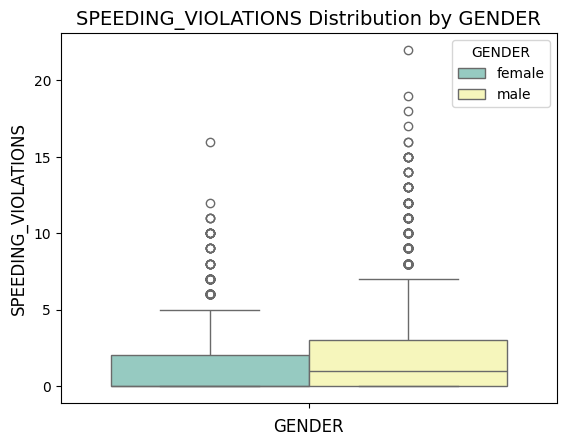

In [59]:
boxplot_gender_speeding_violations = create_boxplot_for_2_columns(df['GENDER'], df['SPEEDING_VIOLATIONS'])
plt.show()

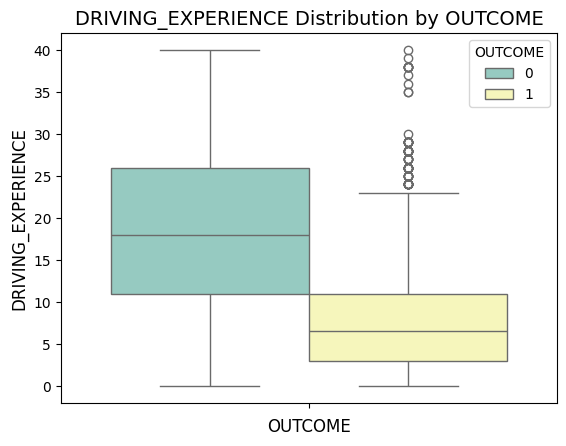

In [60]:
boxplot_outcome_driving_experience = create_boxplot_for_2_columns(df['OUTCOME'], df['DRIVING_EXPERIENCE'])
plt.show()

### Violin Plots

In [62]:
def create_violin_plot_of_2_columns(column1: pd.Series, column2: pd.Series):    
    plt.figure(figsize=(10, 6))
    sns.violinplot(
        hue = column1,
        y=column2,
        palette='coolwarm'
    )
    plt.title(f'Violin Plot of {column2.name} by {column1.name}', fontsize=14)
    plt.xlabel(column1.name, fontsize=12)
    plt.ylabel(f'Number of {column2.name}', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.show()

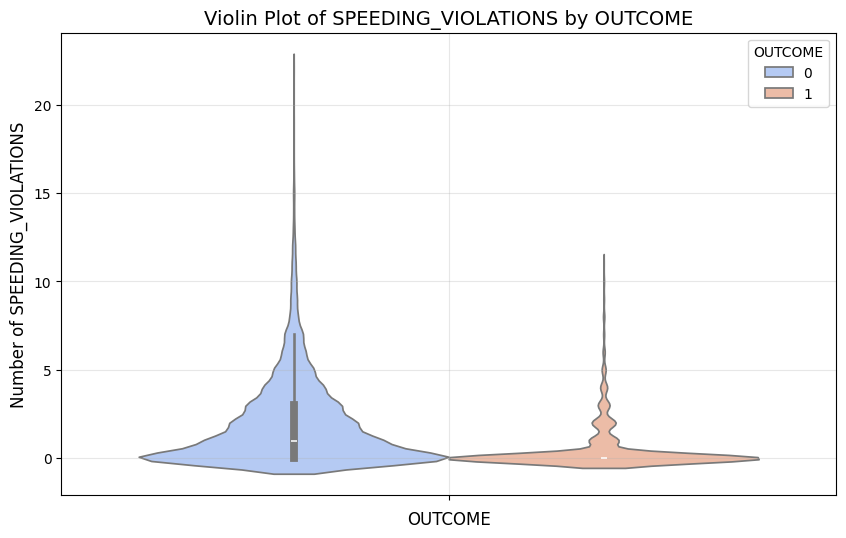

In [63]:
create_violin_plot_of_2_columns(df['OUTCOME'], df['SPEEDING_VIOLATIONS'])

### Relation between Past Accidents and Outcome

In [64]:
def create_histogram_of_accidents_and_outcome_relations(past_accidents: pd.Series, outcome: pd.Series):
    plt.figure(figsize=(10, 6))
    plt.title('Histogram of Past Accidents and Outcome Relations', fontsize=14)

    # Plot the histogram with count plot
    ax = sns.countplot(
        x=past_accidents,
        hue=outcome,
        palette='coolwarm'
    )

    # Calculate percentages for OUTCOME = 1
    percentage_dict = {}
    for value in past_accidents.unique():
        # Align both Series with the DataFrame indices
        count = past_accidents[(past_accidents == value) & (outcome == 1)].shape[0]  # Count where OUTCOME = 1
        total = past_accidents[past_accidents == value].shape[0]  # Total count for this value
        percentage_dict[value] = (count / total) * 100 if total > 0 else 0  # Calculate percentage

    # Create percentage table data
    percentage_table_data = pd.DataFrame({
        'Past Accidents': list(percentage_dict.keys()),
        '% of OUTCOME = 1': [f'{value:.1f}%' for value in percentage_dict.values()]
    }).sort_values(by=['Past Accidents'], ascending=True)

    # Add the table to the plot
    table_ax = plt.gcf().add_axes([0.75, 0.2, 0.2, 0.6])  # Adjust subplot position for the table
    table_ax.axis('tight')
    table_ax.axis('off')

    # Create the table
    table_data = percentage_table_data.values
    table_columns = percentage_table_data.columns
    table_ax.table(cellText=table_data, colLabels=table_columns, loc='center', cellLoc='center')

    # Titles and labels
    plt.xlabel('Number of Past Accidents', fontsize=12)
    plt.ylabel('Count', fontsize=12)
    plt.grid(True, alpha=0.3)
    # plt.tight_layout()
    plt.show()


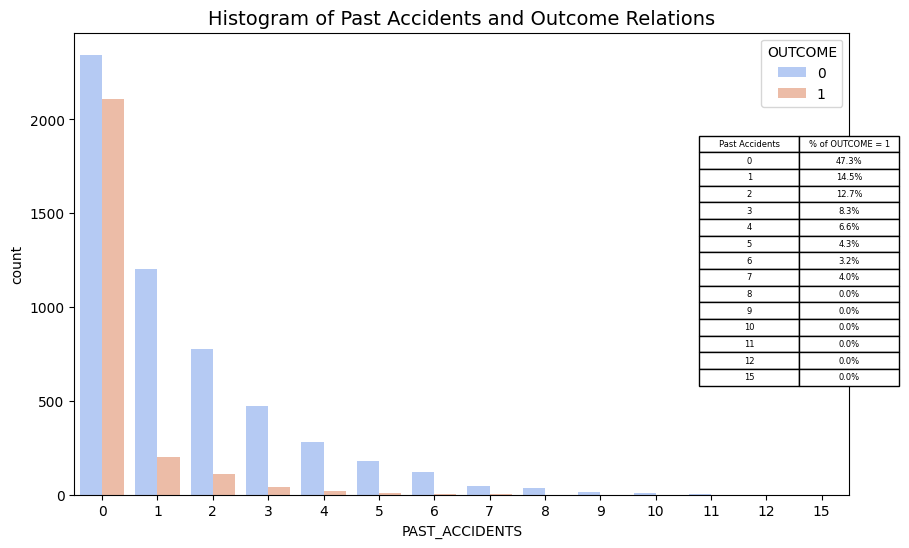

In [65]:
create_histogram_of_accidents_and_outcome_relations(df['PAST_ACCIDENTS'], df['OUTCOME'])

## Pre-Process

In [ ]:
# TODO
"""
1. how many missing values do we have? in what columns?
    a. how to deal with them
2. descretization to the categorial
3. descretization to the continous
4. df.info
"""

### Discretize Categorical Columns

In [68]:
categorical_columns = df.select_dtypes(exclude=['float64', 'int64'])

indexed_mappings = {}
for col in categorical_columns.columns:
    unique_values = df[col].unique()
    mapping = {value: idx for idx, value in enumerate(unique_values)}
    indexed_mappings[col] = mapping

print(json.dumps(indexed_mappings, indent=4))


{
    "GENDER": {
        "female": 0,
        "male": 1
    },
    "EDUCATION": {
        "high school": 0,
        "none": 1,
        "university": 2
    },
    "INCOME": {
        "upper class": 0,
        "poverty": 1,
        "middle class": 2,
        "working class": 3
    },
    "VEHICLE_YEAR": {
        "after 2015": 0,
        "before 2015": 1
    },
    "VEHICLE_TYPE": {
        "sedan": 0,
        "sports car": 1
    }
}


In [69]:
for col, mapping in indexed_mappings.items():
    df[col] = df[col].map(mapping)
df.head()

,GENDER,EDUCATION,INCOME,CREDIT_SCORE,VEHICLE_OWNERSHIP,VEHICLE_YEAR,MARRIED,CHILDREN,POSTAL_CODE,ANNUAL_MILEAGE,VEHICLE_TYPE,SPEEDING_VIOLATIONS,PAST_ACCIDENTS,AGE,DRIVING_EXPERIENCE,OUTCOME
0,0,0,0,0.545417,1,0,1,1,10238,8000.0,0,4,6,80,39,0
1,1,1,1,0.361876,0,1,1,1,10238,9000.0,0,0,0,26,2,1
2,0,2,2,0.535840,1,1,1,0,10238,12000.0,0,0,0,29,7,0
3,0,0,0,0.612545,1,0,1,0,32765,9000.0,0,3,0,60,13,0
4,1,2,2,0.474268,1,1,0,0,32765,13000.0,0,0,0,52,0,1


### Correlation Map

In [ ]:
def create_correlation_heat_map(df: pd.DataFrame):
    plt.figure(figsize=(12, 8))
    sns.heatmap(df, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
    plt.title('Correlation Matrix Heatmap', fontsize=14)
    plt.show()

correlation_matrix = df.corr()
create_correlation_heat_map(correlation_matrix)

### איכות הנתונים

In [ ]:
#finding Null
missing_values = df.isnull().sum()

# הצגת כמות הערכים החסרים בכל עמודה
print("כמות הערכים החסרים בכל עמודה:")
print(missing_values)

In [ ]:
print(df)

### descretization example

In [15]:
from sklearn.preprocessing import KBinsDiscretizer

def categorize_attributes_values(df): # categorize attributes values
    continuous_columns = ['DISTANCE_GROUP', 'SEGMENT_NUMBER', 'CONCURRENT_FLIGHTS',
                          'AVG_MONTHLY_PASS_AIRPORT', 'FLT_ATTENDANTS_PER_PASS',
                          'GROUND_SERV_PER_PASS', 'PLANE_AGE', 'PRCP', 'SNOW', 'SNWD', 'TMAX', 'AWND']
    categorical_columns = ['CARRIER_NAME', 'DEPARTING_AIRPORT']
    unuseful_numerical_columns = ['NUMBER_OF_SEATS', 'LATITUDE', 'LONGITUDE', 'AIRLINE_FLIGHTS_MONTH', 'AIRLINE_AIRPORT_FLIGHTS_MONTH',
                                  'AVG_MONTHLY_PASS_AIRLINE','AIRPORT_FLIGHTS_MONTH']
    unuseful_string_columns = ['PREVIOUS_AIRPORT']
    
    # categorize month, day of week and time block as discrete values
    df['MONTH'] = df['MONTH'].apply(categorize_month)
    df['DAY_OF_WEEK'] = df['DAY_OF_WEEK'].apply(categorize_day_of_week)
    df['DEP_TIME_BLK'] = df['DEP_TIME_BLK'].apply(categorize_time_block)
    
    # categorize continuous values as discrete values
    for column in continuous_columns:
        if df[column].nunique() > 1:
            est = KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='uniform')
            transformed = est.fit_transform(df[[column]])
            df[column] = transformed.T[0]
        else:
            df[column] = 0  # If the column has only one unique value, assign 0 to all entries

    discrete_map = {0: 'Low', 1: 'Medium', 2: 'High'}
    for column in continuous_columns:
        df[column] = df[column].map(discrete_map)

    for column in categorical_columns:
        top_categories = df[column].value_counts().nlargest(5).index
        df[column] = df[column].apply(lambda x: x if x in top_categories else 'Other')

    # categorize unuseful numerical columns as discrete values
    medians = df[unuseful_numerical_columns].quantile(q=0.5, axis=0, numeric_only=False, interpolation='linear')
    for column in unuseful_numerical_columns:
        top_categories = df[column].value_counts().nlargest(2).index
        df[column] = df[column].apply(lambda x: x if x in top_categories else medians[column])

    # categorize unuseful string columns as discrete values
    for column in unuseful_string_columns:
        df[column] = df[column].apply(categorize_string_values)
    
    return df